In [2]:
import os
import gc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = 'btc_data_extended'
fname = 'btc_usd_1min.csv'
data = pd.read_csv(os.path.join(data_dir, fname), index_col=0)

# Find extremum values

In [3]:
c_vals = data.c.values  # close values
extremums = np.zeros(shape=(len(c_vals)))  # initializing an array of extremum values


# searching for extremums on close data values

for i in range(len(c_vals)-1):
    if c_vals[i+1] <= c_vals[i]:
        for j in range(i+1, len(c_vals)):
            if (c_vals[j] - c_vals[i]) / c_vals[i] <= -0.005:
                extremums[i] = 1
                break
            if (c_vals[j] > c_vals[i]):
                extremums[i] = 0
                break
            j += 1
    else:
        flag = False
        j = i+1
        for j in range(i+1, len(c_vals)):
            if (c_vals[j] - c_vals[i]) / c_vals[i] >= 0.005:
                extremums[i] = -1
                break
            if (c_vals[j] < c_vals[i]):
                extremums[i] = 0
                break
            j += 1

            
idxs = np.where(extremums!=0)[0] # get indices of extremums


# reduce duplicates

for i in range(len(idxs)):
    if extremums[idxs[i]] != 0:
        for j in range(i+1, len(idxs)):
            if extremums[idxs[j]] == extremums[idxs[i]]:
                extremums[idxs[j]] = 0
            else:
                break

                
# write values to a separate dataframe column

data['e_class'] = extremums


# bring all points to relative form 

idxs = np.where(extremums!=0)[0]
for i in range(1, len(idxs)):
    for j in range(idxs[i-1]+1, idxs[i]):
        extremums[j] = (((c_vals[j] - c_vals[idxs[i-1]]) / \
                         (c_vals[idxs[i]] - c_vals[idxs[i-1]])) * 2 - 1) * (extremums[idxs[i]])

        
# write values to a separate dataframe column

data['e_regr'] = extremums

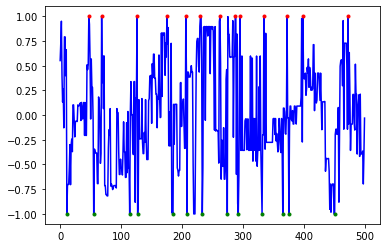

In [10]:
# draw a slice of an array with regressive values

plt.plot(data.e_regr.values[500:1000], 'b')
plt.plot(np.where(data.e_class.values[500:1000] == 1)[0], 
         data.e_class.values[500:1000][np.where(data.e_class.values[500:1000] == 1)[0]], 'r.')
plt.plot(np.where(data.e_class.values[500:1000] == -1)[0], 
         data.e_class.values[500:1000][np.where(data.e_class.values[500:1000] == -1)[0]], 'g.')

In [12]:
data.e_class.value_counts()  # show value counts

 0.0    3525079
-1.0      49689
 1.0      49689
Name: e_class, dtype: int64

In [15]:
data.to_csv(os.path.join(data_dir, fname))  # save updated dataframe

In [3]:
train_dir = 'btc_data_extended/train_slices'
val_dir = 'btc_data_extended/val_slices'

# Making extremum areas and split data into slices

In [4]:
# making areas from intervals between extremums: negative, neutral and positive

def get_triple_ex(data, thr):
    res = np.zeros_like(data)
    res[data < -thr] = -1
    res[data > thr] = 1
    return res


# split data into  slices and save to specific folders

def save_slices(save_dir, slices=36, mode='train'):
    
    for i in range(slices):
        data = pd.read_csv(os.path.join(save_dir, f's{i+1}.csv'), index_col=0)
        data['e_bin'] = np.where(data['e_regr'].values > 0, 1, 0)
        data['e_trip'] = get_triple_ex(data['e_regr'], 0.28)  # 0.28 is optimal threshold for making balanced classes
        data.to_csv(os.path.join(save_dir, f's{i+1}.csv'))
        print(f'{mode} data {i+1}/{slices} saved')


In [ ]:
save_slices(train_dir, mode='train') # saving train slices
save_slices(val_dir, mode='val') # saving val slices